<a href="https://colab.research.google.com/github/IvanHoeFX/TelecomX_latam/blob/main/TelecomX_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extracción

In [2]:
import requests
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data)
df.head()

# JSON anidado → normalizar (aplanar)
df_raw = pd.json_normalize(data, sep=".")
print("Dimensiones (crudo):", df_raw.shape)
df_raw.head(5)

Dimensiones (crudo): (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


#🔧 Transformación

In [3]:
df = df_raw.copy()

# --- normalizar strings (espacios, casing)
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

# --- tipar numéricos principales
num_cols = ["customer.tenure", "account.Charges.Monthly", "account.Charges.Total"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# --- reglas de coherencia de servicios
internet_addons = [
    "internet.OnlineSecurity","internet.OnlineBackup","internet.DeviceProtection",
    "internet.TechSupport","internet.StreamingTV","internet.StreamingMovies"
]

# si NO hay internet → todos los add-ons a "No"
mask_no_inet = df["internet.InternetService"].str.lower().eq("no")
df.loc[mask_no_inet, internet_addons] = "No"

# si NO hay telefonía → múltiples líneas = "No"
mask_no_phone = df["phone.PhoneService"].str.lower().eq("no")
df.loc[mask_no_phone, "phone.MultipleLines"] = "No"

# --- totales incoherentes: Total==0 con tenure>0 → marcar como faltante
mask_incoh_total = (df["account.Charges.Total"].fillna(0) == 0) & (df["customer.tenure"].fillna(0) > 0)
df.loc[mask_incoh_total, "account.Charges.Total"] = np.nan

# --- crear Cuentas_Diarias a partir de facturación mensual
DIAS_PROMEDIO_MES = 30.437
df["Cuentas_Diarias"] = (df["account.Charges.Monthly"] / DIAS_PROMEDIO_MES).round(2)

# --- estandarización opcional: mapear yes/no a binario cuando aplique
bin_map = {"yes":1, "no":0, "si":1, "sí":1, "no internet service":0, "no phone service":0}
def try_binary_map(series: pd.Series) -> pd.Series:
    vals = series.dropna().astype(str).str.lower().unique()
    if set(vals).issubset(set(bin_map.keys())):
        return series.astype(str).str.lower().map(bin_map).astype("Int64")
    return series

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = try_binary_map(df[col])

# --- renombrado a nombres legibles (snake case)
df = df.rename(columns={
    "customerID":"id_cliente",
    "Churn":"churn",
    "customer.gender":"genero",
    "customer.SeniorCitizen":"adulto_mayor",
    "customer.Partner":"pareja",
    "customer.Dependents":"dependientes",
    "customer.tenure":"antiguedad_meses",
    "phone.PhoneService":"servicio_telefonia",
    "phone.MultipleLines":"multiples_lineas",
    "internet.InternetService":"servicio_internet",
    "internet.OnlineSecurity":"seguridad_en_linea",
    "internet.OnlineBackup":"respaldo_en_linea",
    "internet.DeviceProtection":"proteccion_dispositivo",
    "internet.TechSupport":"soporte_tecnico",
    "internet.StreamingTV":"tv_cable",
    "internet.StreamingMovies":"peliculas_streaming",
    "account.Contract":"tipo_contrato",
    "account.PaperlessBilling":"factura_online",
    "account.PaymentMethod":"metodo_pago",
    "account.Charges.Monthly":"facturacion_mensual",
    "account.Charges.Total":"facturacion_total",
})

# --- churn a 0/1 conservando texto en columna auxiliar
if df["churn"].dtype == "object":
    df["churn_str"] = df["churn"]
    df["churn"] = df["churn"].astype(str).str.lower().map({"yes":1,"no":0}).astype("Int64")
else:
    # si ya era 0/1, armamos versión string
    df["churn_str"] = df["churn"].map({1:"Yes", 0:"No"})

# --- columna auxiliar: total de servicios activos (donde 1=activo)
servicios_bin = [
    "servicio_telefonia","multiples_lineas","seguridad_en_linea","respaldo_en_linea",
    "proteccion_dispositivo","soporte_tecnico","tv_cable","peliculas_streaming"
]
presentes = [c for c in servicios_bin if c in df.columns and pd.api.types.is_integer_dtype(df[c])]
df["total_servicios"] = df[presentes].sum(axis=1).astype("Int64") if presentes else pd.array([pd.NA]*len(df), dtype="Int64")

# --- eliminar duplicados por id
df = df.drop_duplicates(subset=["id_cliente"]).reset_index(drop=True)

print("Dimensiones (limpio):", df.shape)
df.head(5)


Dimensiones (limpio): (7267, 24)


,id_cliente,churn,genero,adulto_mayor,pareja,dependientes,antiguedad_meses,servicio_telefonia,multiples_lineas,servicio_internet,...,tv_cable,peliculas_streaming,tipo_contrato,factura_online,metodo_pago,facturacion_mensual,facturacion_total,Cuentas_Diarias,churn_str,total_servicios
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,...,1,0,One year,1,Mailed check,65.6,593.30,2.16,No,4
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,...,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.97,No,3
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,...,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.43,Yes,2
3,0011-IGKFF,1,Male,1,1,0,13,1,0,Fiber optic,...,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.22,Yes,5
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,Fiber optic,...,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.76,Yes,3


#📊 Carga y análisis

Guardado: data/processed/clientes_limpio.parquet | data/processed/clientes_limpio.csv

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_cliente              7267 non-null   object 
 1   churn                   7043 non-null   Int64  
 2   genero                  7267 non-null   object 
 3   adulto_mayor            7267 non-null   int64  
 4   pareja                  7267 non-null   Int64  
 5   dependientes            7267 non-null   Int64  
 6   antiguedad_meses        7267 non-null   int64  
 7   servicio_telefonia      7267 non-null   Int64  
 8   multiples_lineas        7267 non-null   Int64  
 9   servicio_internet       7267 non-null   object 
 10  seguridad_en_linea      7267 non-null   Int64  
 11  respaldo_en_linea       7267 non-null   Int64  
 12  proteccion_dispositivo  7267 non-null   Int64 

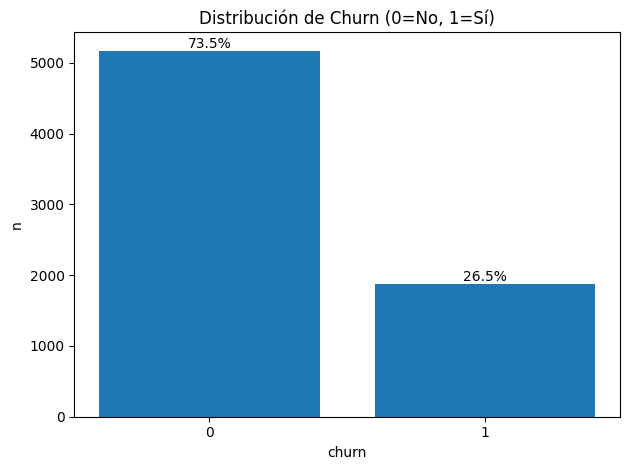

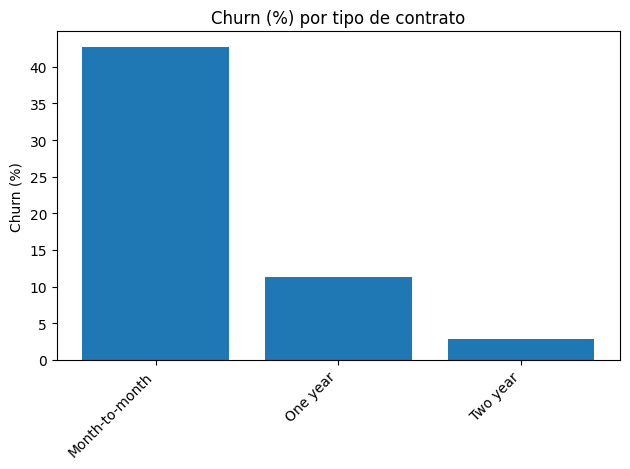

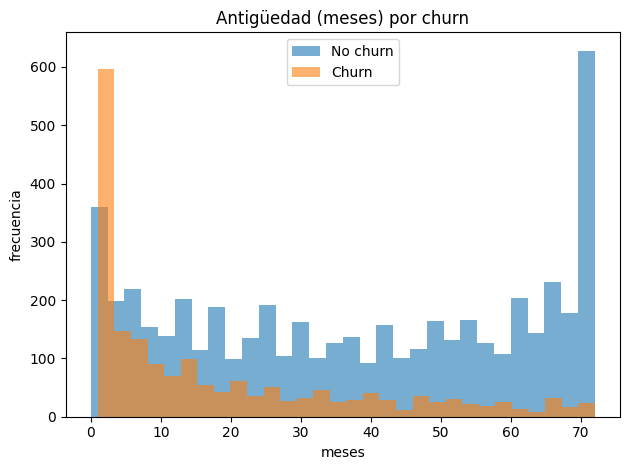

In [13]:
# Guardar dataset limpio (para reutilizar en el resto del análisis)
# Cambia la ruta si deseas guardarlo en tu estructura local
clean_parquet_path = "data/processed/clientes_limpio.parquet"
clean_csv_path     = "data/processed/clientes_limpio.csv"

import os
os.makedirs("data/processed", exist_ok=True)
df.to_parquet(clean_parquet_path, index=False)
df.to_csv(clean_csv_path, index=False)
print("Guardado:", clean_parquet_path, "|", clean_csv_path)

# --- Perfil rápido
print("\n--- Info ---")
print(df.info())

print("\n--- Nulos (top) ---")
print(df.isna().sum().sort_values(ascending=False).head(12))

print("\n--- Descriptivo numérico ---")
print(df[["antiguedad_meses","facturacion_mensual","facturacion_total","Cuentas_Diarias","total_servicios"]]
      .describe())

# --- Distribución de churn (conteo y %)
print("\n--- Distribución de churn ---")
churn_counts = df["churn"].value_counts(dropna=False)
churn_pct = (churn_counts / churn_counts.sum() * 100).round(2)
print(pd.DataFrame({"conteo": churn_counts, "porcentaje_%": churn_pct}))

# --- Tasa de churn por variables categóricas clave (si están en formato binario o categoría)
cat_vars = [
    "genero","tipo_contrato","metodo_pago","servicio_internet",
    "factura_online","servicio_telefonia","multiples_lineas",
    "seguridad_en_linea","respaldo_en_linea","proteccion_dispositivo",
    "soporte_tecnico","tv_cable","peliculas_streaming"
]
print("\n--- Tasa de churn por categorías ---")
for var in cat_vars:
    if var in df.columns:
        tasa = df.groupby(var)["churn"].mean().mul(100).sort_values(ascending=False)
        print(f"\n{var}:\n", tasa)

# --- Comparación de numéricos por churn (media ± std)
print("\n--- Numéricos por churn (media ± std) ---")
numericos = ["antiguedad_meses","facturacion_mensual","facturacion_total","Cuentas_Diarias","total_servicios"]
res = df.groupby("churn")[numericos].agg(["mean","std","median","min","max"]).round(2)
res

# Gráficos rápidos para el EDA
import matplotlib.pyplot as plt

# Gráfico de barras churn
plt.figure()
vals = df["churn"].value_counts().sort_index()
plt.bar(vals.index.astype(str), vals.values)
plt.title("Distribución de Churn (0=No, 1=Sí)")
plt.xlabel("churn")
plt.ylabel("n")
for i, v in enumerate(vals.values):
    pct = v / vals.values.sum() * 100
    plt.text(i, v, f"{pct:.1f}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# Tasa de churn por tipo de contrato (si existe)
if "tipo_contrato" in df.columns:
    tmp = df.groupby("tipo_contrato")["churn"].mean().mul(100).sort_values(ascending=False)
    plt.figure()
    plt.bar(tmp.index.astype(str), tmp.values)
    plt.title("Churn (%) por tipo de contrato")
    plt.ylabel("Churn (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Hist comparativo de antigüedad por churn
if "antiguedad_meses" in df.columns:
    plt.figure()
    plt.hist(df[df["churn"]==0]["antiguedad_meses"].dropna(), bins=30, alpha=0.6, label="No churn")
    plt.hist(df[df["churn"]==1]["antiguedad_meses"].dropna(), bins=30, alpha=0.6, label="Churn")
    plt.title("Antigüedad (meses) por churn")
    plt.xlabel("meses")
    plt.ylabel("frecuencia")
    plt.legend()
    plt.tight_layout()
    plt.show()



#📄Informe final

In [14]:
from datetime import date

def resumen_markdown(df: pd.DataFrame) -> str:
    churn_counts = df["churn"].value_counts(dropna=False)
    tasa = (churn_counts.get(1, 0) / churn_counts.sum() * 100) if churn_counts.sum() else np.nan
    return f"""
# Informe — Telecom X (Churn)
**Fecha:** {date.today().isoformat()}

## Introducción
Análisis de evasión de clientes (Churn) usando datos demográficos, servicios, contrato y facturación.

## Limpieza y Transformación (resumen)
- Normalización de JSON anidado.
- Coherencia de servicios: sin internet ⇒ add-ons en "No"; sin telefonía ⇒ múltiples líneas = "No".
- Conversión numérica de `tenure`, `Charges.Monthly` y `Charges.Total`.
- Creación de **Cuentas_Diarias**.
- Estandarización de `churn` a 0/1 y renombrado de columnas a snake_case.
- Cálculo de **total_servicios** activos.

## Distribución de churn
- Tasa global de churn (aprox): **{tasa:.2f}%**.

## Pistas iniciales
- Contratos *month-to-month* suelen mostrar mayor churn que planes anuales/bianuales.
- Métodos de pago automáticos tienden a menor churn vs. electronic check.
- Menor antigüedad se asocia con mayor churn.

## Recomendaciones
- Incentivar migración de contrato mensual → anual.
- Promover pagos automáticos con beneficios.
- Programas de onboarding/fidelización en los primeros meses.
"""

print(resumen_markdown(df))



# Informe — Telecom X (Churn)
**Fecha:** 2025-08-09

## Introducción
Análisis de evasión de clientes (Churn) usando datos demográficos, servicios, contrato y facturación.

## Limpieza y Transformación (resumen)
- Normalización de JSON anidado.
- Coherencia de servicios: sin internet ⇒ add-ons en "No"; sin telefonía ⇒ múltiples líneas = "No".
- Conversión numérica de `tenure`, `Charges.Monthly` y `Charges.Total`.
- Creación de **Cuentas_Diarias**.
- Estandarización de `churn` a 0/1 y renombrado de columnas a snake_case.
- Cálculo de **total_servicios** activos.

## Distribución de churn
- Tasa global de churn (aprox): **25.72%**.

## Pistas iniciales
- Contratos *month-to-month* suelen mostrar mayor churn que planes anuales/bianuales.
- Métodos de pago automáticos tienden a menor churn vs. electronic check.
- Menor antigüedad se asocia con mayor churn.

## Recomendaciones
- Incentivar migración de contrato mensual → anual.
- Promover pagos automáticos con beneficios.
- Programas de onb